## Instituto Superior de Gestão e Administração de Santarém
### Curso PG em Data Science



##### a22210497 – Inês Luís
##### a22203942 – Rodrigo Antunes
##### a22210477 – Tiago Flor


#### Docente: Prof. Pedro Sobreiro


#### Unidade Curricular: Processamento de Big Data

#### Santarém - Ano letivo 2022-2023

# 1. Introdução

O presente estudo é realizado no âmbito da unidade curricular de processamento de big data da pós-graduação de Data Science. 

Este estudo tem como objetivo aplicabilidade de um algoritmo em machine learning com recurso ao pyspark.
Como origem de dados para tratamento e análise, recorreu-se à utilização de um dataset pré-existente, denominado ‘HBO Max TV Shows and Movies’, obtido através da plataforma Kaggle, em https://www.kaggle.com/. 
A montagem do algoritmo deu-se com recurso do jupyter notebook, com recurso à linguagem markdown para formatar e estruturar o texto. 

O dataset caracteriza-se por uma lista de todos os programas disponíveis na plataforma streaming da HBO Max. Os dados que o constituem foram adquiridos em maio de 2022 nos Estados Unidos.
A análise ao referido dataset tem como objetivo facilitar, na ótica de um potencial investidor ou grupo de investidores, um estudo de possível receção de mercado, tendo como principal indicador a pontuação IMDB, sendo que se pretende, através do modelo construído, prever qual a pontuação esperada que uma nova série, com determinados atributos, poderá atingir.

# 2. Metodologia

O trabalho foi desenvolvido no jupyter notebook. Após importação das bibliotecas necessárias, e visualização do dataset, estudou-se a estrutura de dados. 

In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import regexp_replace, split, col, count, countDistinct

import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("HBO Max TV Shows and Movies").getOrCreate()
spark

#### Importação do dataset

In [7]:
hbo_df = spark.read.csv(r"/titles.csv", header=True, inferSchema=True)
hbo_df.show(5)

+--------+------------------+-----+--------------------+------------+-----------------+-------+--------------------+--------------------+-------+---------+----------+----------+---------------+----------+
|      id|             title| type|         description|release_year|age_certification|runtime|              genres|production_countries|seasons|  imdb_id|imdb_score|imdb_votes|tmdb_popularity|tmdb_score|
+--------+------------------+-----+--------------------+------------+-----------------+-------+--------------------+--------------------+-------+---------+----------+----------+---------------+----------+
|tm155702|  The Wizard of Oz|MOVIE|Young Dorothy fin...|        1939|                G|    102|['fantasy', 'fami...|              ['US']|   null|tt0032138|       8.1|  389774.0|         41.442|       7.6|
| tm83648|      Citizen Kane|MOVIE|Newspaper magnate...|        1941|               PG|    119|           ['drama']|              ['US']|   null|tt0033467|       8.3|  433804.0|   

#### Tipos de dados

In [8]:
hbo_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: string (nullable = true)
 |-- imdb_votes: string (nullable = true)
 |-- tmdb_popularity: string (nullable = true)
 |-- tmdb_score: string (nullable = true)



#### Conversão de dados string para numéricos (int, double, float)

In [9]:
hbo_df = hbo_df.withColumn('release_year', col('release_year').cast('integer'))
hbo_df = hbo_df.withColumn('seasons', col('seasons').cast('integer'))
hbo_df = hbo_df.withColumn('imdb_votes', col('imdb_votes').cast('integer'))
hbo_df = hbo_df.withColumn('runtime', col('runtime').cast('double'))
hbo_df = hbo_df.withColumn('tmdb_popularity', col('tmdb_popularity').cast('double'))
hbo_df = hbo_df.withColumn('imdb_score', col('imdb_score').cast('double'))

Com base na importação e tratamento preliminar, verifica-se que o conjunto de dados do dataset está representado em 15 atributos, todos estes do tipo string. Neste sentido, com base na análise que se pretende efetuar, foram efetuadas algumas conversões através da função ‘cast’. As colunas ‘release_year’, ‘seasons’, 'imdb_votes' estavam inicialmente num formato ‘string’ e foram convertidas para o formato ‘integer’. As colunas 'runtime' 'tmdb_popularity' e 'imdb_score' também estavam inicialmente num formato ‘string’, mas foram convertidas para o formato 'double'.

#### Validação das conversões efetuadas

In [10]:
hbo_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: double (nullable = true)
 |-- imdb_votes: integer (nullable = true)
 |-- tmdb_popularity: double (nullable = true)
 |-- tmdb_score: string (nullable = true)



Após as conversões, é possível analisar os dados numéricos da base de dados, e, nesse sentido, foi utilizado o método "describe" para verificar a estatística descritiva e visualizadas através do método “show” (limitado a 6 caracteres, ‘truncate’=6).

#### Dados Estatisticos

In [11]:
summary = hbo_df.describe()
summary.show(truncate = 6)

+-------+------+------+------+-----------+------------+-----------------+-------+------+--------------------+-------+-------+----------+----------+---------------+----------+
|summary|    id| title|  type|description|release_year|age_certification|runtime|genres|production_countries|seasons|imdb_id|imdb_score|imdb_votes|tmdb_popularity|tmdb_score|
+-------+------+------+------+-----------+------------+-----------------+-------+------+--------------------+-------+-------+----------+----------+---------------+----------+
|  count|  3334|  3334|  3331|       3319|        3116|             2141|   3157|  3289|                3291|    738|   2947|      2799|      2819|           3178|      3010|
|   mean|  null|151...|199...|     124...|      199...|           186...| 106...|741...|              602...| 91....| 492...|    114...|    630...|         170...|    308...|
| stddev|  null|893...|11....|     100...|      74....|           503...| 220...|917...|              877...| 828...| 114...|

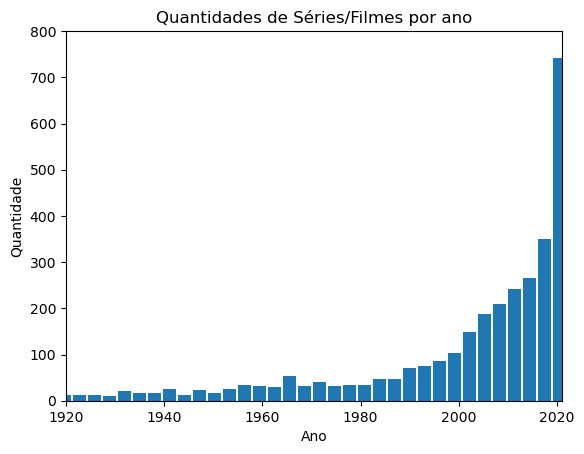

In [12]:
year = hbo_df.select('release_year')
year = year.toPandas()

year.hist(column = 'release_year',grid = False,histtype='bar',bins=655,rwidth=0.9)
plt.title("Quantidades de Séries/Filmes por ano")
plt.xlabel('Ano')
plt.xlim(1920,2021)
plt.ylabel('Quantidade')
plt.ylim(0,800)
plt.show()

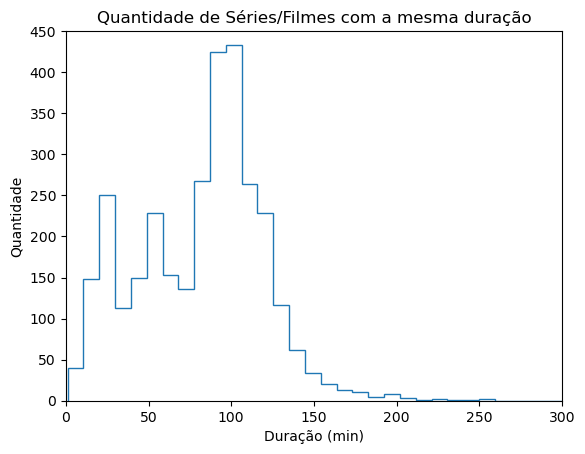

In [13]:
duration = hbo_df.select('runtime')
duration = duration.toPandas()

duration.hist(column = 'runtime',grid = False, bins = 211,histtype='step')
plt.title("Quantidade de Séries/Filmes com a mesma duração")
plt.xlabel('Duração (min)')
plt.xlim(0,300)
plt.ylabel('Quantidade')
plt.ylim(0,450)
plt.show()

In [14]:
tv_shows_by_rating_df = hbo_df.groupBy('imdb_score').agg(count('*').alias('Count'))
tv_shows_by_rating_df = tv_shows_by_rating_df.filter(tv_shows_by_rating_df['imdb_score'] < 10)
tv_shows_by_rating_df_sorted = tv_shows_by_rating_df.sort('imdb_score', ascending = False)
tv_shows_by_rating_df_sorted.show(95)

+----------+-----+
|imdb_score|Count|
+----------+-----+
|       9.4|    3|
|       9.3|    3|
|       9.2|    5|
|       9.0|    8|
|       8.9|    7|
|       8.8|   11|
|       8.7|   18|
|       8.6|   22|
|       8.5|   33|
|       8.4|   30|
|       8.3|   48|
|       8.2|   58|
|       8.1|   76|
|       8.0|   83|
|       7.9|   74|
|       7.8|   82|
|       7.7|   98|
|       7.6|  101|
|       7.5|  106|
|       7.4|  131|
|       7.3|  121|
|       7.2|  110|
|       7.1|  112|
|       7.0|   99|
|       6.9|   94|
|       6.8|   92|
|       6.7|   97|
|       6.6|  101|
|       6.5|  102|
|       6.4|   87|
|       6.3|   76|
|       6.2|   77|
|     6.175|    1|
|       6.1|   64|
|       6.0|   52|
|       5.9|   47|
|       5.8|   50|
|       5.7|   50|
|       5.6|   42|
|       5.5|   38|
|       5.4|   39|
|       5.3|   31|
|       5.2|   28|
|       5.1|   18|
|       5.0|   21|
|       4.9|    9|
|       4.8|   11|
|       4.7|   12|
|       4.6|   10|
|     4.595|

Com recurso à biblioteca ‘Matplotlib’, foi elaborado um histograma que mostra a quantidade de séries e filmes lançados entre os anos de 1920 e 2020. É percetível através do gráfico que existe uma tendência: há medida que os anos vão passando, o número de series/filmes, lançados vai aumentando. Na última década, este aumento foi bastante mais acentuado. Os avanços tecnológicos, o aumento dos serviços das plataformas de streaming, e até a mudança dos hábitos de consumo dos espetadores, justificam o aumento significativo na produção e lançamento de series e filmes na última década.

De seguida, foi elaborado um novo histograma que reflete a quantidade de series/filmes com a mesma duração (min). O gráfico demonstra haver outliers no que respeita a series/filmes com uma duração superior a 200 minutos.

Foi ainda elaborada uma análise à variável pontuação ('imdb_score'), sendo que a classificação mais vezes atribuída em series/filmes é 7,4 (131 vezes), seguida de 7,3 (121 vezes).

#### Separação de dados em diferentes colunas

De seguida, por forma a melhor adequar o dataframe ao estudo pretendido, separou-se o género de serie/filme em diferentes colunas. Realizou-se inicialmente uma limpeza à variável ‘genres’: através da criação de uma nova coluna, aplicando as funções ‘genres_clean’ e regexp_replace’ tendo-se removido alguns caracteres especiais (parênteses retos). Após esse tratamento, dividiu-se o string com a utilização de virgulas, utilizando a função ‘spliti. Por fim, foi criada uma nova coluna para cada item da string, utilizado o método ‘getItem’. 


In [15]:
# Separar o genero de filme/serie em diferentes colunas

# Primeiro criámos uma nova coluna sem os '[]'
genres_df = hbo_df.withColumn('genres_clean', regexp_replace(col('genres'), '\[|\]', ''))

# Depois dividimos a string na virgula.
genres_df = genres_df.withColumn('genre_array', split(col('genres_clean'), ','))

# Por fim, criamos uma nova coluna para cada item da string
genres_df = genres_df.withColumn("genre_0", col("genre_array").getItem(0))
genres_df = genres_df.withColumn("genre_1", col("genre_array").getItem(1))
genres_df = genres_df.withColumn("genre_2", col("genre_array").getItem(2))

# Visualizar todas as colunas criadas
genres_df.select('genres','genres_clean','genre_0','genre_1','genre_2').show(100)

+--------------------+--------------------+-----------+----------------+----------------+
|              genres|        genres_clean|    genre_0|         genre_1|         genre_2|
+--------------------+--------------------+-----------+----------------+----------------+
|['fantasy', 'fami...| 'fantasy', 'family'|  'fantasy'|        'family'|            null|
|           ['drama']|             'drama'|    'drama'|            null|            null|
|['drama', 'romanc...|'drama', 'romance...|    'drama'|       'romance'|           'war'|
|['thriller', 'cri...| 'thriller', 'crime'| 'thriller'|         'crime'|            null|
|['thriller', 'rom...|'thriller', 'roma...| 'thriller'|       'romance'|         'crime'|
|                 233|                 233|        233|            null|            null|
|['animation', 'co...|'animation', 'com...|'animation'|        'comedy'|        'family'|
|['western', 'drama']|  'western', 'drama'|  'western'|         'drama'|            null|
|         

In [16]:
genres_df=genres_df.dropna()
rating_count = genres_df.select(countDistinct("genre_0")).collect()[0][0]
print('Esta coluna tem',genres_df.select('genre_0').count(),"linhas e",rating_count,"valores unicos.")
genres_df.select('genre_0').distinct().show(20)

Esta coluna tem 281 linhas e 14 valores unicos.
+---------------+
|        genre_0|
+---------------+
|    'animation'|
|'documentation'|
|        'drama'|
|      'reality'|
|       'comedy'|
|        'crime'|
|       'family'|
|        'scifi'|
|          'war'|
|      'fantasy'|
|       'action'|
|      'western'|
|     'thriller'|
|      'romance'|
+---------------+



#### Valores Nulos

Posteriormente, foi efetuada a análise aos valores nulos, e, no sentido de evitar enviesamento nos dados, determinou-se que os valores nulos seriam eliminados.

In [17]:
#Verificar quantos valores nulos existem em cada coluna.
for colu in hbo_df.columns:
    print(colu, "=", hbo_df.filter(hbo_df[colu].isNotNull()).count(), "valores NÃO nulos e",
          hbo_df.filter(hbo_df[colu].isNull()).count(),"valores nulos")

id = 3334 valores NÃO nulos e 0 valores nulos
title = 3334 valores NÃO nulos e 0 valores nulos
type = 3331 valores NÃO nulos e 3 valores nulos
description = 3319 valores NÃO nulos e 15 valores nulos
release_year = 3116 valores NÃO nulos e 218 valores nulos
age_certification = 2141 valores NÃO nulos e 1193 valores nulos
runtime = 3157 valores NÃO nulos e 177 valores nulos
genres = 3289 valores NÃO nulos e 45 valores nulos
production_countries = 3291 valores NÃO nulos e 43 valores nulos
seasons = 738 valores NÃO nulos e 2596 valores nulos
imdb_id = 2947 valores NÃO nulos e 387 valores nulos
imdb_score = 2799 valores NÃO nulos e 535 valores nulos
imdb_votes = 2819 valores NÃO nulos e 515 valores nulos
tmdb_popularity = 3178 valores NÃO nulos e 156 valores nulos
tmdb_score = 3010 valores NÃO nulos e 324 valores nulos


In [18]:
# Apagar todas as linhas com nulls.
hbo_df=hbo_df.dropna()

In [19]:
# Confirmação de todos os null apagados.
for colu in hbo_df.columns:
    print(colu, "=", hbo_df.filter(hbo_df[colu].isNotNull()).count(), "valores NÃO nulos e",
          hbo_df.filter(hbo_df[colu].isNull()).count(),"valores nulos")

id = 493 valores NÃO nulos e 0 valores nulos
title = 493 valores NÃO nulos e 0 valores nulos
type = 493 valores NÃO nulos e 0 valores nulos
description = 493 valores NÃO nulos e 0 valores nulos
release_year = 493 valores NÃO nulos e 0 valores nulos
age_certification = 493 valores NÃO nulos e 0 valores nulos
runtime = 493 valores NÃO nulos e 0 valores nulos
genres = 493 valores NÃO nulos e 0 valores nulos
production_countries = 493 valores NÃO nulos e 0 valores nulos
seasons = 493 valores NÃO nulos e 0 valores nulos
imdb_id = 493 valores NÃO nulos e 0 valores nulos
imdb_score = 493 valores NÃO nulos e 0 valores nulos
imdb_votes = 493 valores NÃO nulos e 0 valores nulos
tmdb_popularity = 493 valores NÃO nulos e 0 valores nulos
tmdb_score = 493 valores NÃO nulos e 0 valores nulos


#### Aplicação Modelo de Machine Learning - Regressão Linear

Procedemos à aplicabilidade do Modelo de Machine Learning - Regressão Linear. Pretende-se obter com o modelo de regressão um conjunto de coeficientes que minimoze a diferença entre os valores previstos e os valores reais da variável. É através dos coeficientes, que definimos a equação de regressão linear do modelo.

Primeiramente, dividiu-se a base de dados em valores de treino e em valores de teste a fim de obtermos um modelo ajustado. De seguida, foi aplicado o transformador do PySpark (‘VectorAssembler’) para combinar diversas colunas numa única coluna de vetor.

In [20]:
# Dividir a BD em valores de treino e em valores de teste.
train_df, test_df = hbo_df.randomSplit([0.7, 0.3], seed=42)

In [21]:
assembler = VectorAssembler(inputCols=['runtime', 'release_year', 'seasons','imdb_votes','tmdb_popularity',], outputCol='features')

In [22]:
train_features_df = assembler.transform(train_df)
test_features_df = assembler.transform(test_df)

In [23]:
lr = LinearRegression(featuresCol='features', labelCol='imdb_score')

In [24]:
lr_model = lr.fit(train_features_df)

In [25]:
predictions_df = lr_model.transform(test_features_df)

In [2]:
predictions_df(29,2012,4,563,87)

NameError: name 'predictions_df' is not defined

# 3. Resultados Obtidos

### a) Apresentação da pontuação IMDB prevista

In [26]:
view = predictions_df.select('runtime', 'release_year', 'seasons','imdb_votes','tmdb_popularity','imdb_score','prediction')
view.show(10)

+-------+------------+-------+----------+---------------+----------+------------------+
|runtime|release_year|seasons|imdb_votes|tmdb_popularity|imdb_score|        prediction|
+-------+------------+-------+----------+---------------+----------+------------------+
|   29.0|        2006|      1|       518|          0.715|       5.2|  7.23329209686662|
|   58.0|        2020|      1|      3399|          3.696|       7.1| 7.140503098824219|
|   25.0|        2019|      3|      1411|          2.983|       8.1| 6.910319239283503|
|   45.0|        2019|      2|      2335|          5.383|       7.5| 7.069840949014456|
|   22.0|        2014|      6|      2354|           3.72|       7.5| 7.029477082490828|
|   22.0|        2005|      4|     18578|        134.112|       7.4| 7.555607448245915|
|   23.0|        2008|      3|      9789|        110.808|       7.2|7.4179718675948365|
|   23.0|        2010|      3|      7423|        116.779|       7.6|7.3801343703958295|
|   56.0|        2009|      1|  

  Com base na tabela supra, é possível observar os valores previstos pelo modelo de regressão, validando a funcionalidade do modelo e do código utilizado para a sua construção. Adicionalmente, a referida tabela apresenta uma comparação entre a pontuação prevista e a pontuação real constante no dataset.

### b) Avaliação do modelo

Com base nas expressões de avaliação descritas infra, efetuou-se a análise da eficácia do modelo na previsão de resultados.

Para este efeito, foram considerados as métricas Root Mean Square Error (RMSE) e R-squared (R2), sendo que RMSE representa a diferença média entre os valores previstos pelo modelo e os valores atuais (IBM Documentation, s.d.) e R2 representa a proporção da variância na variável dependente que pode ser explicada pela variável independente, ou seja, o quanto os dados se encaixam no modelo de previsão (Abba, 2023).

Relativamente à aplicação destas métricas, é expectável que um modelo ideal apresente RMSE até um intervalo entre 0.50 e 0.80, sendo que quanto menor maior será a precisão, se os dados forem normalizados (SAP Help Portal, s.d.). No âmbito da presente análise, uma vez que não se procedeu à normalização dos dados, uma vez que é pretendido o estudo dos valores dos atributos na sua origem, o RMSE terá de ser considerado tendo em consideração a natureza da base de dados. Relativamente ao R2, deverá ser superior a 0.50, devido a tratar-se de uma previsão de comportamento humano (a atribuição de uma pontuação subjetiva).


In [39]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='imdb_score', metricName='rmse')
rmse = evaluator.evaluate(predictions_df)
evaluator2 = RegressionEvaluator(predictionCol='prediction', labelCol='imdb_score', metricName='r2')
r2 = evaluator2.evaluate(predictions_df)
rmse = float(rmse)
mean = hbo_df.agg({'imdb_score': 'mean'})
mean_collected = mean.collect()[0][0]
RMSE_pct = rmse / mean_collected * 100
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f'RMSE em função da média de pontuação IMDB: {RMSE_pct}')

RMSE: 0.9963188957694896
R2: 0.011930769704008304
RMSE em função da média de pontuação IMDB: 13.606992509678062


Conforme é possível observar, o modelo apresenta um rácio RMSE de 0,996, o que significa que em média, o modelo permite prever a pontuação IMDB para uma determinada séria com um erro de 0,996, ou aproximadamente 1 ponto.

Em termos percentuais, representa um erro de 13,61% face à pontuação esperada.

Relativamente à métrica R2, o modelo apresenta valor de 0,012, o que se demonstra significativamente inferior ao valor esperado para um modelo que represente com confiança o dataset.

In [24]:
intercept = lr_model.intercept
coefficients = lr_model.coefficients
print("Intercept: " + str(intercept))
print("Coefficients: " + str(coefficients))
print("\nExpressão matemática: ")
print("Y (imdb_score) = " + str(round(intercept,4)) + " + \n(" + str(round(coefficients[0],4)) + " x Runtime" + ") + (" + str(round(coefficients[1],4)) + " x Release_Year"+ ") + (" + str(round(coefficients[2],4)) + " x Seasons"") + (" + str(round(coefficients[3],8)) + " x imdb_votes"+ ") + (" + str(round(coefficients[4],4)) + " x tmdb_popularity)")

Intercept: 55.00968228664363
Coefficients: [0.007966449612801966,-0.02393649074243771,0.006741778943805336,1.547099721469274e-06,0.0022937401150349705]

Expressão matemática: 
Y (imdb_score) = 55.0097 + 
(0.008 x Runtime) + (-0.0239 x Release_Year) + (0.0067 x Seasons) + (1.55e-06 x imdb_votes) + (0.0023 x tmdb_popularity)


A expressão supra permite visualizar a fórmula matemática utilizada pelo modelo para efetuar a previsão dos resultados.

# 4. Conclusões

Conforme previamente referido no presente documento, este estudo teve como origem dos seus dados um dataset pré construído, constante da plataforma online 'Kaggle', contendo um repositório de séries e filmes constantes da plataforma de 'streaming' digital, HBO Max. A análise deste dataset visou a elaboração de um modelo de previsão, cujo output final esperado seria indicação da pontuação IMDB que uma possível nova séria com determinados atributos poderia obter.

Para este efeito, foi necessário a importação do dataset, com posterior tratamento dos dados recorrendo ao framework 'PySpark', uma vez que esta ferramente é indicada para tratamento de largos conjuntos de dados. O tratamento realizou-se no sentido de uniformizar o conjunto dos dados para que este esteja adequado aos métodos a aplicar, assim como realização de análises estatísticas preliminares.

Após a constução do modelo de previsão e sucesso na sua execução, observou-se que, efetivamente, é possível a obtenção da previsão inicialmente proposta.

Em análise às previsões efetuadas e à avaliação da robustez e capacidade do modelo, verificou-se que, não obstante ter-se obtido, efetivamente, uma previsão final, a comparação com os dados de teste retorna valores de RMSE e R2 que se situam fora dos valores entendidos como aceitáveis, concluindo-se que o modelo não apresenta uma forte capacidade de previsão. Este fato poderá ter que ver com diversos fatores, estimando-se que o principal fator de erro será a fraca significância dos atributos que constituem o dataset. A dificuldade na obtenção de um conjunto robusto de dados foi notável, sendo que a maioria dos datasets encontrados apresenta dados considerados incompletos para uma análise sólida.

Apesar da previsão com elevado grau de erro que o modelo apresenta, consideramos que, numa ótica de análise preliminar de um possível investimento, ainda assim, o modelo efetivamente apresenta uma previsão de tendência que poderá ser utilizada como possível métrica de receção no mercado.

# 5. Bibliografia

SAP Help Portal. (s.d.). SAP Help Portal. https://help.sap.com/docs/SAP_PREDICTIVE_ANALYTICS/41d1a6d4e7574e32b815f1cc87c00f42/5e5198fd4afe4ae5b48fefe0d3161810.html

IBM Documentation. (s.d.). IBM - Deutschland | IBM. https://www.ibm.com/docs/en/cloud-paks/cp-data/3.0.1?topic=overview-root-mean-squared-error

Abba, I. V. (2023, 28 de março). What is R Squared? R2 Value Meaning and Definition. freeCodeCamp.org. https://www.freecodecamp.org/news/what-is-r-squared-r2-value-meaning-and-definition/